In [2]:
import requests
import datetime
import pandas as pd

# Define the endpoint and parameters
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {
    "vs_currency": "inr",
    "days": "365"
}

# Make the request to the CoinGecko API
response = requests.get(url, params=params)
data = response.json()

# Extract the prices, volumes, and market caps
prices = data['prices']
volumes = data['total_volumes']
market_caps = data['market_caps']

# Prepare the data
data_list = []
for i in range(len(prices)):
    timestamp = prices[i][0] / 1000  # Convert milliseconds to seconds
    date = datetime.datetime.fromtimestamp(timestamp).date()
    price_inr = prices[i][1]
    volume = volumes[i][1]
    market_cap = market_caps[i][1]
    data_list.append([date, price_inr, volume, market_cap])

# Create a DataFrame
df = pd.DataFrame(data_list, columns=['Date', 'Price', 'Volume', 'Market Cap'])
# Ensure Date is the index
df.set_index('Date', inplace=True)
print(df)

                   Price        Volume    Market Cap
Date                                                
2024-02-21  4.331116e+06  2.857737e+12  8.502504e+13
2024-02-22  4.299768e+06  2.539934e+12  8.450888e+13
2024-02-23  4.252977e+06  1.966867e+12  8.347821e+13
2024-02-24  4.213808e+06  1.876255e+12  8.281063e+13
2024-02-25  4.272821e+06  1.287014e+12  8.391681e+13
...                  ...           ...           ...
2025-02-16  8.452534e+06  1.231480e+12  1.675701e+14
2025-02-17  8.331281e+06  1.181446e+12  1.650681e+14
2025-02-18  8.318633e+06  2.199547e+12  1.649374e+14
2025-02-19  8.297395e+06  3.328757e+12  1.644521e+14
2025-02-19  8.358058e+06  3.321206e+12  1.656891e+14

[366 rows x 3 columns]


In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Prepare the dataset for the model
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), :]
        X.append(a)
        Y.append(data[i + time_step, 0])  # Predicting the price
    return np.array(X), np.array(Y)

# Create the dataset
time_step = 30  # Last 30 days
X, Y = create_dataset(scaled_data, time_step)

# Split the data into training and testing sets
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=10)


Epoch 1/10


c:\Users\RISHI\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0079
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0043
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0031
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0034
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0023
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0041
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0021
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0016
Epoch 9/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0017
Epoch 10/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0015


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


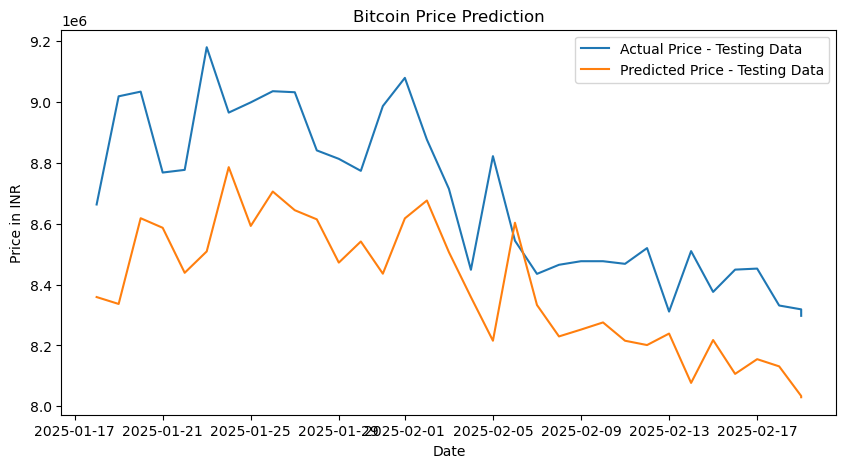

In [5]:
# Evaluate the model
# train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
# train_predict = scaler.inverse_transform(np.concatenate((train_predict, X_train[:, -1, 1:]), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, X_test[:, -1, 1:]), axis=1))[:, 0]

# Get the actual values
# Y_train_actual = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
Y_test_actual = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# plt.plot(df.index[-len(Y_train_actual):], Y_train_actual, label='Actual Price - Training Data')
plt.plot(df.index[-len(Y_test_actual):], Y_test_actual, label='Actual Price - Testing Data')
# plt.plot(df.index[-len(Y_train_actual):], train_predict, label='Predicted Price - Training Data')
plt.plot(df.index[-len(Y_test_actual):], test_predict, label='Predicted Price - Testing Data')
plt.xlabel('Date')
plt.ylabel('Price in INR')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()


In [6]:
print(test_predict)

[8359040.18102549 8336381.91670511 8617976.21268676 8586567.91753935
 8438724.30419154 8508940.91886583 8785715.031774   8592663.51779819
 8705633.9871771  8644271.8874947  8614319.26691625 8472143.84551544
 8541518.66708804 8435778.62031391 8617457.04774289 8676212.0751188
 8506577.44561795 8358961.74390456 8215627.82102695 8603164.32436236
 8333008.52852652 8229731.11136068 8252198.75867773 8275686.97653438
 8215578.09485217 8201386.00777775 8239084.66403522 8077033.2761888
 8217884.73818601 8106663.8605877  8155018.71770555 8131373.92159617
 8034022.50291446 8030018.06589874]


In [7]:
print(Y_test_actual)

[8663111.83095711 9018449.19233623 9033786.62168703 8768042.95878533
 8776811.21901726 9179681.60309149 8964946.04927235 8998507.68711584
 9035194.85987907 9031820.5753885  8840730.32175964 8813004.62310299
 8773589.21760404 8986342.54237369 9079030.83473236 8876282.25488476
 8714560.72971515 8448647.56832192 8821899.22031773 8544188.02843914
 8435196.80812457 8465025.73274424 8476794.46058341 8476775.26242149
 8468155.63074401 8519902.0973004  8311326.25852567 8509967.7861991
 8375908.59898433 8449165.8343421  8452533.70025346 8331280.75796871
 8318633.34814442 8297394.50077834]


In [8]:
price_diff = test_predict[-1]-Y_test_actual[-1]
print(price_diff)

-267376.434879601


[3.50995873 7.56302177 4.60283629 2.06973257 3.85204725 7.30679683
 1.99924257 4.51012749 3.64752369 4.29092545 2.56099945 3.86770224
 2.6451039  6.12667411 5.08395439 2.25398623 2.3866181  1.0615406
 6.87234556 0.69025045 1.21145104 2.77960905 2.64953578 2.37222623
 2.9826747  3.73849471 0.86919455 5.0873813  1.88664739 4.05367797
 3.51983196 2.39947305 3.42136543 3.2224144 ]


Text(0.5, 0, 'No. of Day')

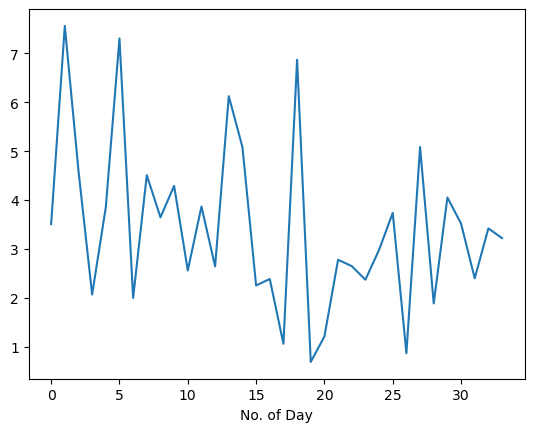

In [9]:
price_diff = []  # Initialize the list outside of the loop

for i in range(0, 34):
    diff = 100*(test_predict[i] - Y_test_actual[i])/Y_test_actual[i] #Calculate the percentage
    price_diff.append(diff)  # Append the difference to the list

# Convert the list to a 1D NumPy array
price_diff_array = abs(np.array(price_diff))
print(price_diff_array)
plt.plot(price_diff_array)
plt.xlabel('No. of Day')

In [10]:
price_diff_array.min()

0.6902504454129585

In [11]:
price_diff_array.max()

7.563021768872771

In [12]:
X_test

array([[[0.96462675, 0.4745647 , 0.9688564 ],
        [0.87256581, 0.58675288, 0.87459192],
        [0.82862834, 0.51501404, 0.83193483],
        ...,
        [0.79964096, 0.39002651, 0.80374276],
        [0.83435329, 0.25029538, 0.83839962],
        [0.8976603 , 0.28543634, 0.9016755 ]],

       [[0.87256581, 0.58675288, 0.87459192],
        [0.82862834, 0.51501404, 0.83193483],
        [0.82255678, 0.57779509, 0.82460656],
        ...,
        [0.83435329, 0.25029538, 0.83839962],
        [0.8976603 , 0.28543634, 0.9016755 ],
        [0.89597605, 0.24442242, 0.89956319]],

       [[0.82862834, 0.51501404, 0.83193483],
        [0.82255678, 0.57779509, 0.82460656],
        [0.81424854, 0.25497575, 0.81638439],
        ...,
        [0.8976603 , 0.28543634, 0.9016755 ],
        [0.89597605, 0.24442242, 0.89956319],
        [0.96753191, 0.34976434, 0.97206507]],

       ...,

       [[0.96753191, 0.34976434, 0.97206507],
        [0.97062048, 0.24032521, 0.97501472],
        [0.9171065 , 0

In [13]:
Y_test

array([0.89597605, 0.96753191, 0.97062048, 0.9171065 , 0.9188722 ,
       1.        , 0.95675775, 0.96351621, 0.97090406, 0.97022457,
       0.93174388, 0.92616063, 0.91822338, 0.96106646, 0.97973151,
       0.93890313, 0.90633655, 0.85278843, 0.92795178, 0.87202784,
       0.8500798 , 0.85608658, 0.8584565 , 0.85845263, 0.85671686,
       0.86713728, 0.82513543, 0.86513676, 0.83814067, 0.8528928 ,
       0.853571  , 0.82915376, 0.82660689, 0.82232993])

In [14]:
X

array([[[0.02362291, 0.14923185, 0.0224499 ],
        [0.01731021, 0.12885866, 0.01721709],
        [0.0078877 , 0.09212151, 0.00676797],
        ...,
        [0.28186926, 0.23763148, 0.27982138],
        [0.19037064, 0.3928325 , 0.19073728],
        [0.2866113 , 0.34348545, 0.283397  ]],

       [[0.01731021, 0.12885866, 0.01721709],
        [0.0078877 , 0.09212151, 0.00676797],
        [0.        , 0.08631269, 0.        ],
        ...,
        [0.19037064, 0.3928325 , 0.19073728],
        [0.2866113 , 0.34348545, 0.283397  ],
        [0.2497138 , 0.22420721, 0.24657438]],

       [[0.0078877 , 0.09212151, 0.00676797],
        [0.        , 0.08631269, 0.        ],
        [0.01188376, 0.04853862, 0.01121455],
        ...,
        [0.2866113 , 0.34348545, 0.283397  ],
        [0.2497138 , 0.22420721, 0.24657438],
        [0.22053663, 0.19344605, 0.21757939]],

       ...,

       [[0.96753191, 0.34976434, 0.97206507],
        [0.97062048, 0.24032521, 0.97501472],
        [0.9171065 , 0

In [15]:
last_sequence = scaled_data[-time_step:]
def predict_future(model, data, days_ahead, time_step):
    temp_input = data[-time_step:].reshape(1, time_step, data.shape[1])
    predictions = []
    for _ in range(days_ahead):
        prediction = model.predict(temp_input)
        predictions.append(prediction[0, 0])
        temp_input = np.append(temp_input[:, 1:, :], [[np.append(prediction, temp_input[:, -1, 1:])]], axis=1)
    return predictions


In [16]:
# Predict the next day, week, and month
next_day_prediction = predict_future(model, scaled_data, 1, time_step)
next_week_prediction = predict_future(model, scaled_data, 7, time_step)
next_month_prediction = predict_future(model, scaled_data, 30, time_step)

# Inverse transform to get actual values
next_day_price = scaler.inverse_transform(np.concatenate((np.array(next_day_prediction).reshape(-1, 1), np.zeros((1, 2))), axis=1))[:, 0]
next_week_price = scaler.inverse_transform(np.concatenate((np.array(next_week_prediction).reshape(-1, 1), np.zeros((7, 2))), axis=1))[:, 0]
next_month_price = scaler.inverse_transform(np.concatenate((np.array(next_month_prediction).reshape(-1, 1), np.zeros((30, 2))), axis=1))[:, 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [17]:
next_day_price

array([8080300.10827857])

C:\Users\RISHI\AppData\Local\Temp\ipykernel_19944\635397982.py:3: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(dates, week, 'g')


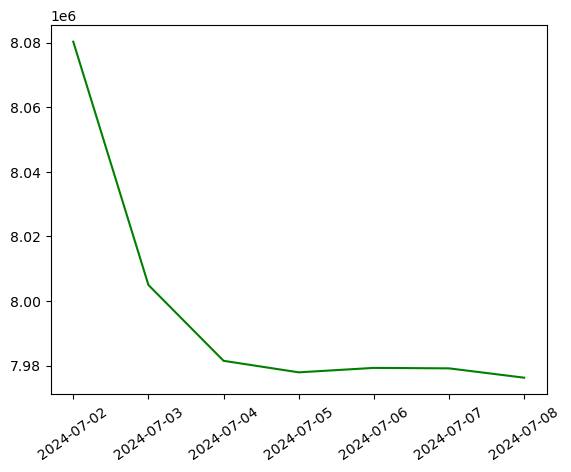

In [18]:
week = next_week_price
dates = pd.date_range(start='7/2/2024',periods=7)
plt.plot_date(dates, week, 'g')
plt.xticks(rotation=35)
plt.show()

C:\Users\RISHI\AppData\Local\Temp\ipykernel_19944\3716881554.py:3: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(dates, month, 'g')


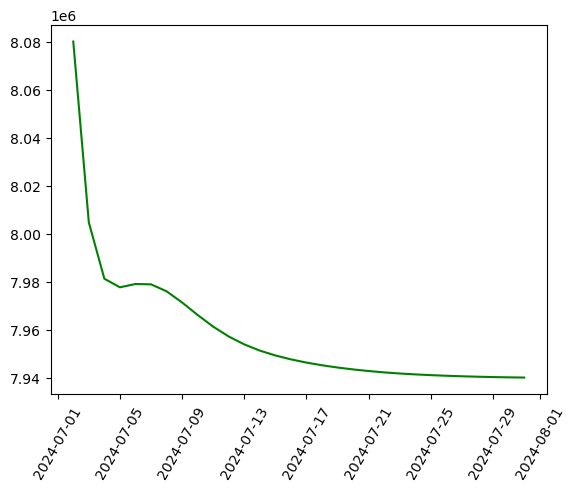

In [19]:
month = next_month_price
dates = pd.date_range(start='7/2/2024',periods=30)
plt.plot_date(dates, month, 'g')
plt.xticks(rotation=60)
plt.show()

In [27]:
import pickle
next_month_price
next_week_price
next_day_price
pickle.dump(next_day_price,open('next_day_price.pkl','wb'))
pickle.dump(next_week_price,open('next_week_price.pkl','wb'))
pickle.dump(next_month_price,open('next_month_price.pkl','wb'))

In [28]:
next_week_price[6]

7976266.438871245

In [25]:
print(type(next_week_price))

<class 'numpy.ndarray'>
